<a href="https://colab.research.google.com/github/sahar7888/GAN_Models/blob/main/CoGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Conditional GANs

In [17]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import os
import zipfile
import gdown
from torch.autograd import Variable
from torchvision.utils import save_image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_train = zipfile.ZipFile('/content/drive/MyDrive/data.zip','r')
zip_train.extractall('/temp')
zip_train.close()

In [4]:
# Root directory for dataset
dataroot = '/temp/data/img_align_celeba'

In [5]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 10

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 3

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


# The interval between image sampling.
sample_interval = 400

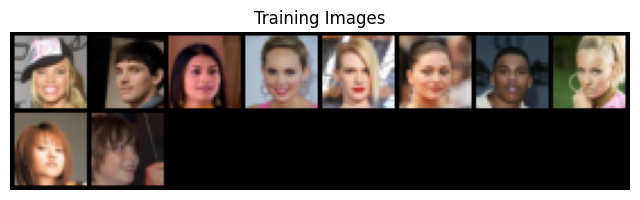

In [6]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))


# Create the dataloader
dataloader1 = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

dataloader2 = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader1))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
class CoupledGenerators(nn.Module):
    def __init__(self):
        super(CoupledGenerators, self).__init__()

        self.init_size = image_size // 4
        self.fc = nn.Sequential(nn.Linear(nz, 128 * self.init_size ** 2))

        self.shared_conv = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
        )
        self.G1 = nn.Sequential(
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, nc, 3, stride=1, padding=1),
            nn.Tanh(),
        )
        self.G2 = nn.Sequential(
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, nc, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise):
        out = self.fc(noise)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img_emb = self.shared_conv(out)
        img1 = self.G1(img_emb)
        img2 = self.G2(img_emb)
        return img1, img2

In [9]:
class CoupledDiscriminators(nn.Module):
    def __init__(self):
        super(CoupledDiscriminators, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            block.extend([nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)])
            return block

        self.shared_conv = nn.Sequential(
            *discriminator_block(nc, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )
        # The height and width of downsampled image
        ds_size = image_size // 2 ** 4
        self.D1 = nn.Linear(128 * ds_size ** 2, 1)
        self.D2 = nn.Linear(128 * ds_size ** 2, 1)

    def forward(self,img1, img2):
        # Determine validity of first image
        out = self.shared_conv(img1)
        out = out.view(out.shape[0], -1)
        validity1 = self.D1(out)
        # Determine validity of second image
        out = self.shared_conv(img2)
        out = out.view(out.shape[0], -1)
        validity2 = self.D2(out)

        return validity1, validity2

In [10]:
# Create the generators
netG = CoupledGenerators().to(device)

# Initialize weights
netG.apply(weights_init)

# Print the model
print(netG)

CoupledGenerators(
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
  )
  (shared_conv): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
  )
  (G1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Tanh()
  )
  (G2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64

In [11]:
# Create the discriminators
netD = CoupledDiscriminators().to(device)

# Initialize weights
netD.apply(weights_init)

# Print the model
print(netD)

CoupledDiscriminators(
  (shared_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout2d(p=0.25, inplace=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout2d(p=0.25, inplace=False)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout2d(p=0.25, inplace=False)
 

In [13]:
# Initialize MSELoss function
loss = nn.MSELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
#fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [20]:
Tensor = torch.cuda.FloatTensor
!mkdir images
for epoch in range(num_epochs):
    for i, ((imgs1, _), (imgs2, _)) in enumerate(zip(dataloader1, dataloader2)):

        batch_size = imgs1.shape[0]

        # Adversarial ground truths
        valid = Variable(Tensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        imgs1 = Variable(imgs1.type(Tensor).expand(imgs1.size(0), 3, image_size, image_size))
        imgs2 = Variable(imgs2.type(Tensor))

        # ------------------
        #  Train Generators
        # ------------------

        optimizerG.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (batch_size, nz))))

        # Generate a batch of images
        gen_imgs1, gen_imgs2 = netG(z)
        # Determine validity of generated images
        validity1, validity2 = netD(gen_imgs1, gen_imgs2)

        g_loss = (loss(validity1, valid) + loss(validity2, valid)) / 2

        g_loss.backward()
        optimizerG.step()

        # ----------------------
        #  Train Discriminators
        # ----------------------

        optimizerD.zero_grad()

        # Determine validity of real and generated images
        validity1_real, validity2_real = netD(imgs1, imgs2)
        validity1_fake, validity2_fake = netD(gen_imgs1.detach(), gen_imgs2.detach())

        d_loss = (
            loss(validity1_real, valid)
            + loss(validity1_fake, fake)
            + loss(validity2_real, valid)
            + loss(validity2_fake, fake)
        ) / 4

        d_loss.backward()
        optimizerD.step()



        batches_done = epoch * len(dataloader1) + i
        if batches_done % sample_interval == 0:
            gen_imgs = torch.cat((gen_imgs1.data, gen_imgs2.data), 0)
            save_image(gen_imgs, "images/%d.png" % batches_done, nrow=8, normalize=True)
            print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, num_epochs, i, len(dataloader1), d_loss.item(), g_loss.item())
            )


[Epoch 0/3] [Batch 0/20260] [D loss: 0.481860] [G loss: 0.962931]
[Epoch 0/3] [Batch 400/20260] [D loss: 0.270382] [G loss: 0.279908]
[Epoch 0/3] [Batch 800/20260] [D loss: 0.257113] [G loss: 0.236694]
[Epoch 0/3] [Batch 1200/20260] [D loss: 0.253050] [G loss: 0.279772]
[Epoch 0/3] [Batch 1600/20260] [D loss: 0.249212] [G loss: 0.255443]
[Epoch 0/3] [Batch 2000/20260] [D loss: 0.254495] [G loss: 0.275803]
[Epoch 0/3] [Batch 2400/20260] [D loss: 0.235815] [G loss: 0.256785]
[Epoch 0/3] [Batch 2800/20260] [D loss: 0.255234] [G loss: 0.230571]
[Epoch 0/3] [Batch 3200/20260] [D loss: 0.244876] [G loss: 0.235839]
[Epoch 0/3] [Batch 3600/20260] [D loss: 0.242106] [G loss: 0.262641]
[Epoch 0/3] [Batch 4000/20260] [D loss: 0.263196] [G loss: 0.236187]
[Epoch 0/3] [Batch 4400/20260] [D loss: 0.263962] [G loss: 0.243049]
[Epoch 0/3] [Batch 4800/20260] [D loss: 0.242062] [G loss: 0.252283]
[Epoch 0/3] [Batch 5200/20260] [D loss: 0.247155] [G loss: 0.243797]
[Epoch 0/3] [Batch 5600/20260] [D loss: